# Scube tutorial: Alignment of consecutive ST slices on human brain MERFISH dataset

July 2023

Dataset: 33 MERFISH slices of mouse brain ([here](https://zenodo.org/record/8135478)).

In [1]:
from SPACEL import Scube
import scanpy as sc
import numpy as np

## Spatial transcriptomic data import

The input data type of Scube is a list of anndata objects for each slice. The anndata objects of each slice must contain a column of spatial domain for alignment in `.obs`.

In [2]:
inputs = []
for i in range(33):
    ad = sc.read('../data/merfish_mouse_brain/merfish_mouse_brain_slice'+str(i)+'.h5ad')
    ad.obsm['spatial']['Z'] = i
    inputs.append(ad)

First, we define the color of each spatial domian.

In [3]:
import seaborn as sns
import matplotlib
import pandas as pd

colors = sns.color_palette(n_colors=7)
colors = [matplotlib.colors.to_hex(c) for c in colors]

color_map = pd.DataFrame(colors,columns=['color'])

for i in range(len(inputs)):
    inputs[i].uns['spa_cluster_colors'] = [color_map.loc[c,'color'] for c in inputs[i].obs['spa_cluster'].cat.categories]

Plot all raw slices SPACELed in a single figure. Spots/cells colored by spatial domain. 

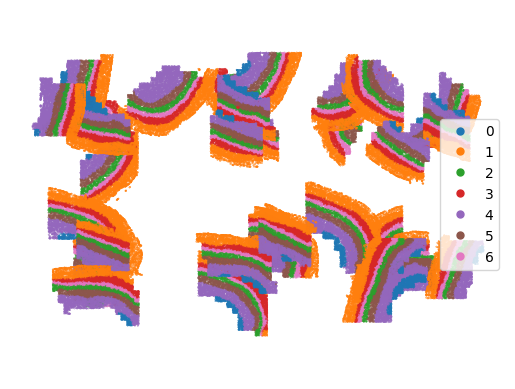

In [5]:
Scube.plot_stacked_slices(inputs,spatial_key='spatial',cluster_key='spa_cluster',s=.1)

## Pairwise alignment

Here, we perform pairwise alignment of slices. The `cluster_key` is the column of .obs which contain spatial domain information used for alignment. The `n_neighbors` affect how much neighbors are considered when calculate similarity of two slices. The `knn_exclude_cutoff` affect max distance of neighbors. By default, `n_neighbors = 25`and `knn_exclude_cutoff = 25` means a spot/cell in source slices consider 25 neighbors in target slices, and neighbor will be exclude when the distance of neighbos larger than the median of neareast 50 neighbors distance in all spot/cell in target slice. `p` affect the exponent of overlap penalty, and a larger `p` means smaller weight of the overlap penalty.

In [6]:
Scube.align(inputs,cluster_key='spa_cluster',n_neighbors=25,knn_exclude_cutoff=25,p=3,n_threads=10)

Start alignment...
Alignment slice 1 to 0
Optimal score: flip = 0.8067564830923237, not flip = 0.8060343143657743
Alignment slice 2 to 1
Optimal score: flip = 0.761647119680566, not flip = 0.806507656089354
Alignment slice 3 to 2
Optimal score: flip = 0.7301748310691615, not flip = 0.7775287265557932
Alignment slice 4 to 3
Optimal score: flip = 0.8360456615055583, not flip = 0.8075905668612221
Alignment slice 5 to 4
Optimal score: flip = 0.8471067443292891, not flip = 0.8362941773617922
Alignment slice 6 to 5
Optimal score: flip = 0.8174326081823868, not flip = 0.833994802858398
Alignment slice 7 to 6
Optimal score: flip = 0.8418926939565063, not flip = 0.7962227667935284
Alignment slice 8 to 7
Optimal score: flip = 0.8720836277293083, not flip = 0.8138858010975188
Alignment slice 9 to 8
Optimal score: flip = 0.8498228505708119, not flip = 0.8071309653617458
Alignment slice 10 to 9
Optimal score: flip = 0.8631488818467004, not flip = 0.8088031647450193
Alignment slice 11 to 10
Optimal 

After alignment, the new spots/cells location coordinates saved in `.obsm['spatial_aligned']` of anndata object of each slices. When `write_loc_path` provied by users, the location coordinates of all spots/cells of all slices will be saved in `write_loc_path`.

## Plot alignment results

Plot all aligned slices stacked in a single figure. 

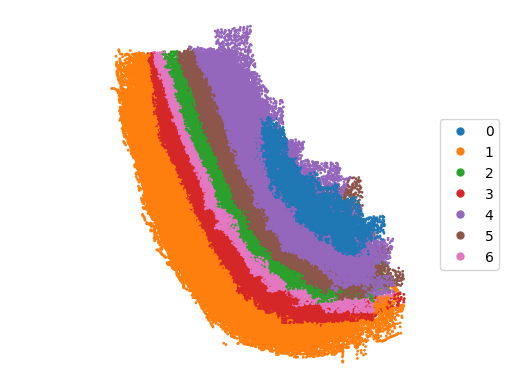

In [7]:
Scube.plot_stacked_slices(inputs,spatial_key='spatial_aligned',cluster_key='spa_cluster')

Save all spots/cells aligned coordiantes and colors in a DataFrame.

In [8]:
coo = pd.DataFrame()
for i in range(len(inputs)):
    loc = inputs[i].obsm['spatial_aligned']
    loc['celltype_colors'] = [color_map.loc[c,'color'] for c in inputs[i].obs['spa_cluster']]
    coo = pd.concat([coo,loc],axis=0)
coo.to_csv('Scube_outputs/aligned_coordinates_colors.csv')

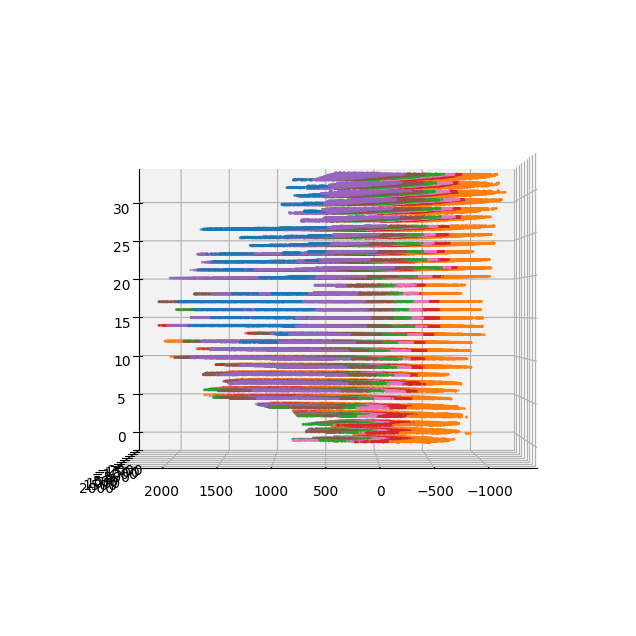

In [9]:
Scube.plot_3d(coo.values[:,:3],val=None,color=coo['celltype_colors'],show=True,elev=0,azim=90,s=1)

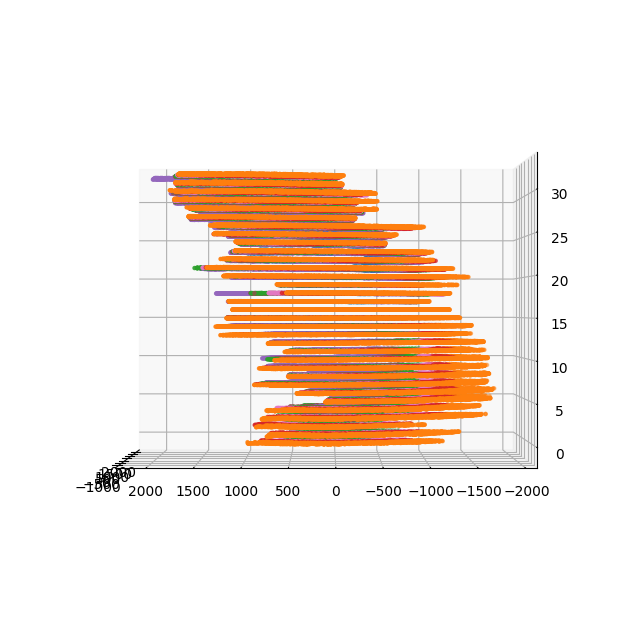

In [10]:
Scube.plot_3d(coo.values[:,:3],val=None,color=coo['celltype_colors'],show=True,elev=0,azim=180,s=5)